In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.models import Model
tf.random.set_seed(7)
np.random.seed(1)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
data = '/content/drive/My Drive/archive/energy-anomaly-detection/train.csv'
df = pd.read_csv(data)
df

,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01 00:00:00,NaN,0
1,32,2016-01-01 00:00:00,NaN,0
2,41,2016-01-01 00:00:00,NaN,0
3,55,2016-01-01 00:00:00,NaN,0
4,69,2016-01-01 00:00:00,NaN,0
...,...,...,...,...
1749489,1316,2016-12-31 23:00:00,38.844,0
1749490,1318,2016-12-31 23:00:00,202.893,0
1749491,1319,2016-12-31 23:00:00,NaN,0
1749492,1323,2016-12-31 23:00:00,172.000,0


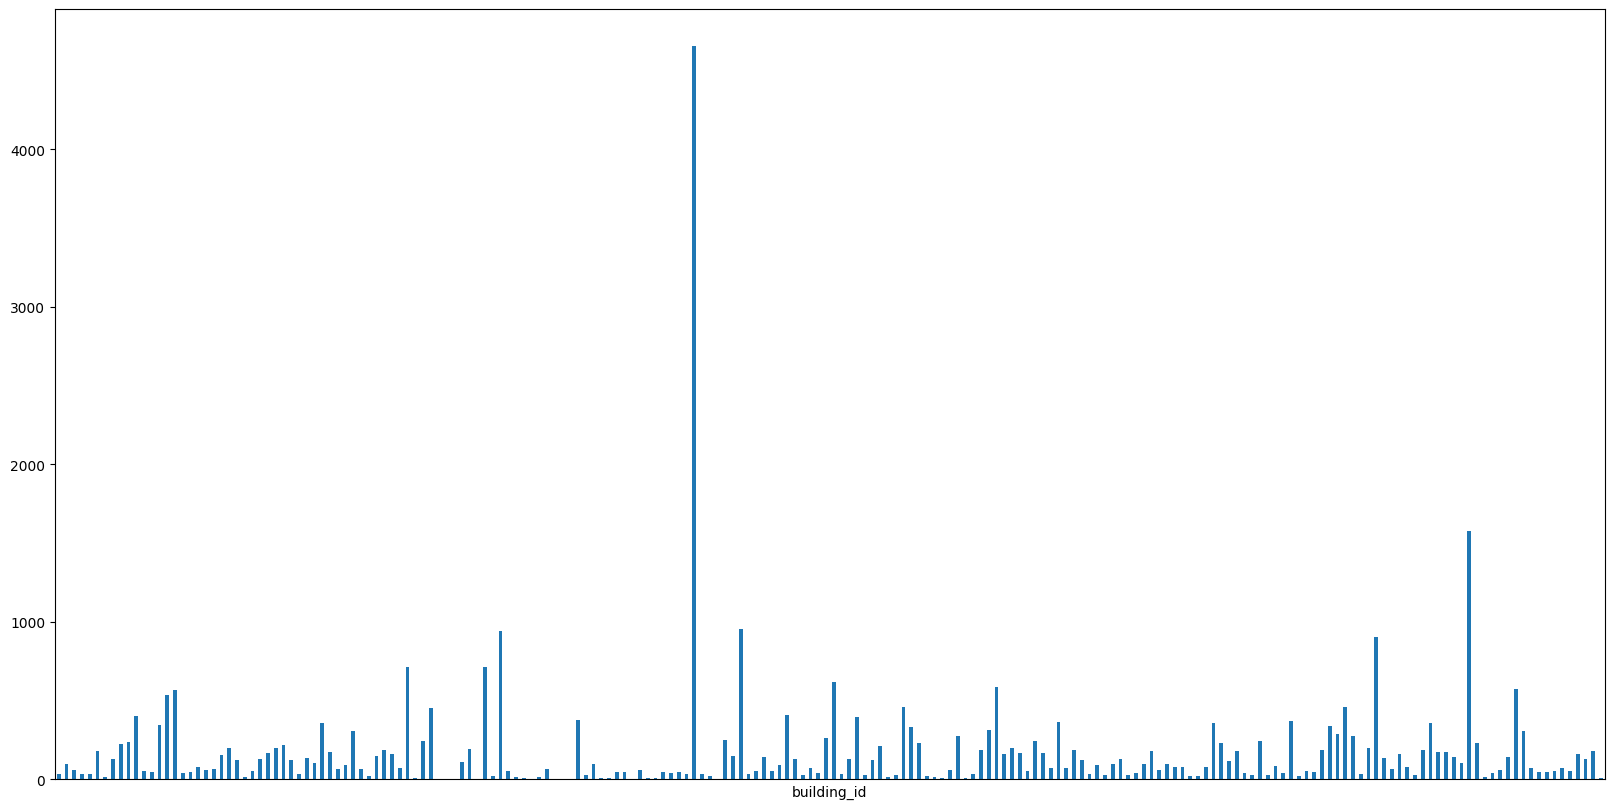

In [26]:
mean_reading = df.groupby('building_id')['meter_reading'].mean()
plt.figure(figsize=(20,10))
mean_reading.plot.bar()
plt.xticks([])
plt.show()

In [27]:
reading_counts = df.groupby('building_id')['meter_reading'].count()
building_with_most_data = reading_counts.idxmax()
max_readings_count = reading_counts.max()
print(f"Building with the most data (ID): {building_with_most_data}")
print(f"Number of readings: {max_readings_count}")

Building with the most data (ID): 118
Number of readings: 8784


In [28]:
df = df[df['building_id'] == 118]
df

,building_id,timestamp,meter_reading,anomaly
13,118,2016-01-01 00:00:00,117.2,0
213,118,2016-01-01 01:00:00,234.4,0
411,118,2016-01-01 02:00:00,234.8,0
610,118,2016-01-01 03:00:00,236.4,0
809,118,2016-01-01 04:00:00,239.8,0
...,...,...,...,...
1748507,118,2016-12-31 19:00:00,321.8,0
1748707,118,2016-12-31 20:00:00,299.0,0
1748907,118,2016-12-31 21:00:00,286.1,0
1749107,118,2016-12-31 22:00:00,280.7,0


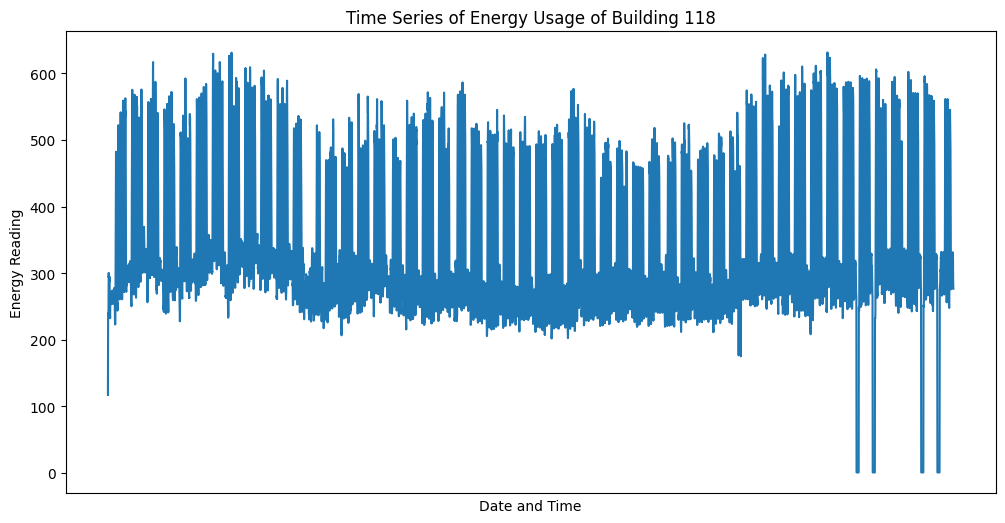

In [29]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df['timestamp'], y=df['meter_reading'])
plt.title(f'Time Series of Energy Usage of Building 118')
plt.xlabel('Date and Time')
plt.ylabel('Energy Reading')
plt.xticks([])
plt.show()

In [30]:
# Calculate split indices chronologically
total_len = len(df)
train_end = int(total_len * 0.8)
val_end = int(total_len * 0.9) # 80% train + 10% validation

# Create dataframes for train, validation, and test sets
train_df = df[:train_end]
val_df = df[train_end:val_end]
test_df = df[val_end:]

train_data = train_df[['meter_reading']]
train_labels = train_df[['anomaly']]
val_data = val_df[['meter_reading']]
val_labels = val_df[['anomaly']]
test_data = test_df[['meter_reading']]
test_labels = test_df[['anomaly']]

In [31]:
# Normalized the time series using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)
scaled_test_data = scaler.transform(test_data)

# Generated overlapping windows of fixed length to feed into the LSTM
# Not shuffling since time series and we don't want to be using future data to predict present

def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
    return np.array(X)

SEQ_LENGTH = 24

X_train = create_sequences(scaled_train_data, SEQ_LENGTH)
Y_train = train_labels.iloc[SEQ_LENGTH:]
X_val = create_sequences(scaled_val_data, SEQ_LENGTH)
Y_val = val_labels.iloc[SEQ_LENGTH:]
X_test = create_sequences(scaled_test_data, SEQ_LENGTH)
Y_test = test_labels.iloc[SEQ_LENGTH:]

In [32]:
def LSTM_compression(data):

  input_dim = data.shape[2]
  timesteps = data.shape[1]

  inputs = Input(shape=(timesteps, input_dim))
  encoded = LSTM(64, activation='relu', return_sequences=False, name="encoder")(inputs)
  decoded = RepeatVector(timesteps)(encoded)
  decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)

  autoencoder = Model(inputs, decoded)
  autoencoder.compile(optimizer='adam', loss='mse')

  autoencoder.fit(data, data, epochs=30, batch_size=64, validation_split=0.1, shuffle=False)

  encoder_model = Model(inputs, encoded)
  latent_vectors = encoder_model.predict(data, verbose=1, batch_size=32)  # shape = (num_samples, 64)

  return encoder_model, latent_vectors

In [33]:
encoder_model, train_latent_vectors = LSTM_compression(X_train)

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.1774 - val_loss: 0.0663
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0539 - val_loss: 0.0511
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0443 - val_loss: 0.0554
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0452 - val_loss: 0.0509
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0416 - val_loss: 0.0487
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0405 - val_loss: 0.0468
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0392 - val_loss: 0.0472
Epoch 8/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0400 - val_loss: 0.0454
Epoch 9/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0405 - val_loss: 0.0423
Epoch 10/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0389 - val_loss: 0.0411
Epoch 11/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0356 - val_loss: 0.0517
Epoch 12/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0379 - val_l

In [34]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Assume you have your full data and labels:
# X_train_latent, y_train_labels (0 for normal, 1 for anomaly)
# X_test_latent, y_test_labels (0 for normal, 1 for anomaly)

def hyperparameter_tuning():
    best_score = 0
    best_params = {}
    precisions = []

    for nu_val in [0.1, 0.15, 0.2]:
        for gamma_val in ['auto', 'scale']:
            normal_train_vectors = train_latent_vectors[Y_train.iloc[:, 0] == 0]

            oc_svm = OneClassSVM(nu=nu_val, kernel='rbf', gamma=gamma_val)
            oc_svm.fit(normal_train_vectors)

            # Evaluate on the validation data
            # Predictions will be +1 (inlier/normal) or -1 (outlier/anomaly)
            val_latent_vectors = encoder_model.predict(X_val, verbose=0, batch_size = 32)
            val_predictions = oc_svm.predict(val_latent_vectors)

            # Remap predictions to 0 (normal) and 1 (anomaly) for comparison with y_test_labels
            remapped_predictions = np.zeros_like(val_predictions)
            remapped_predictions[val_predictions == -1] = 1

            # Calculate metrics
            precision = precision_score(Y_val, remapped_predictions, pos_label=1)
            precisions.append(precision)
            recall = recall_score(Y_val, remapped_predictions, pos_label=1)
            f1 = f1_score(Y_val, remapped_predictions, pos_label=1)

            print(f"Params: nu={nu_val}, gamma={gamma_val} | Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

            # Keep track of the model with the best Precision (TP/FP + TP)
            if precision > best_score:
                best_score = precision
                best_params = {'nu': nu_val, 'gamma': gamma_val}

    print(f"\nBest parameters found: {best_params} with Precision score of {best_score:.4f}")
    return best_params, best_score, precisions

best_params, best_score, precisions = hyperparameter_tuning()

Params: nu=0.1, gamma=auto | Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Params: nu=0.1, gamma=scale | Precision: 0.0562, Recall: 0.8519, F1-Score: 0.1055
Params: nu=0.15, gamma=auto | Precision: 0.0070, Recall: 0.0741, F1-Score: 0.0129
Params: nu=0.15, gamma=scale | Precision: 0.0542, Recall: 0.8889, F1-Score: 0.1021
Params: nu=0.2, gamma=auto | Precision: 0.0094, Recall: 0.1111, F1-Score: 0.0173
Params: nu=0.2, gamma=scale | Precision: 0.0517, Recall: 0.8889, F1-Score: 0.0978

Best parameters found: {'nu': 0.1, 'gamma': 'scale'} with Precision score of 0.0562


In [35]:
test_latent_vectors = encoder_model.predict(X_test, verbose=0, batch_size = 32)

# Use OC-SVM model with best parameters from hyperparameter tuning
if best_params:
  oc_svm = OneClassSVM(nu=best_params['nu'], kernel='rbf', gamma=best_params['gamma'])
else:
  oc_svm = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')

# Train the OC-SVM model on the latent space vectors
# The model learns the boundary of the normal data distribution in this space
oc_svm.fit(train_latent_vectors)

# Predict using the OC-SVM
predictions = oc_svm.predict(test_latent_vectors)

# Remapping prediction labels
anomaly_labels = np.zeros_like(predictions)
anomaly_labels[predictions == -1] = 1

In [36]:
precision = precision_score(Y_test, anomaly_labels, pos_label=1)
recall = recall_score(Y_test, anomaly_labels, pos_label=1)
f1 = f1_score(Y_test, anomaly_labels, pos_label=1)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Precision: 0.2091, Recall: 0.8519, F1-Score: 0.3358


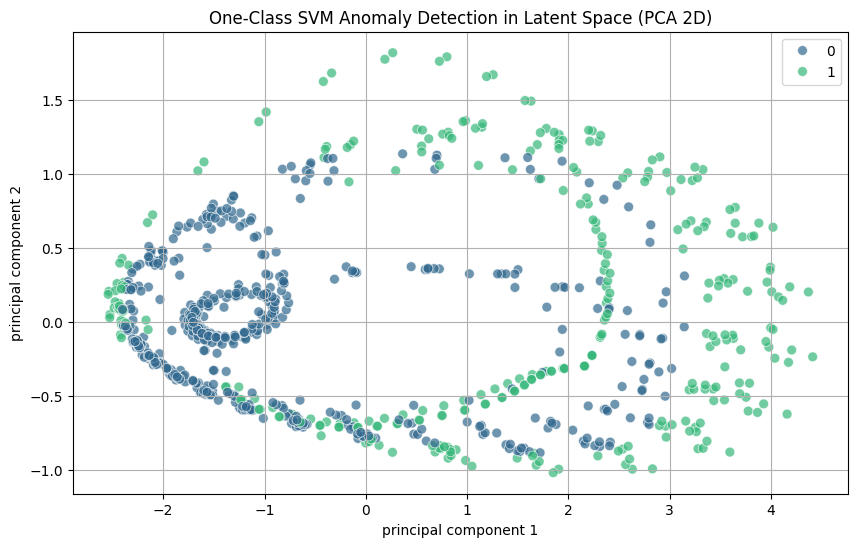

In [37]:
# Visualize the latent space with PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latent_pca = pca.fit_transform(test_latent_vectors)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=latent_pca[:, 0], y=latent_pca[:, 1], hue=anomaly_labels, palette='viridis', s=50, alpha=0.7)
plt.title("One-Class SVM Anomaly Detection in Latent Space (PCA 2D)")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.grid(True)
plt.show()

In [38]:
# Apply KMeans clustering to group similar latent representations
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(test_latent_vectors)

# We assume the larger cluster is "normal"
normal_cluster = np.bincount(labels).argmax()
anomaly_mask = labels != normal_cluster

In [39]:
# Convert boolean mask to integer labels (0 for normal, 1 for anomaly)
kmeans_anomaly_labels = np.zeros_like(anomaly_mask, dtype=int)
kmeans_anomaly_labels[anomaly_mask] = 1

# Calculate metrics
kmeans_precision = precision_score(Y_test, kmeans_anomaly_labels, pos_label=1)
kmeans_recall = recall_score(Y_test, kmeans_anomaly_labels, pos_label=1)
kmeans_f1 = f1_score(Y_test, kmeans_anomaly_labels, pos_label=1)

print(f"K-means Precision: {kmeans_precision:.4f}, Recall: {kmeans_recall:.4f}, F1-Score: {kmeans_f1:.4f}")

K-means Precision: 0.1134, Recall: 0.4691, F1-Score: 0.1827


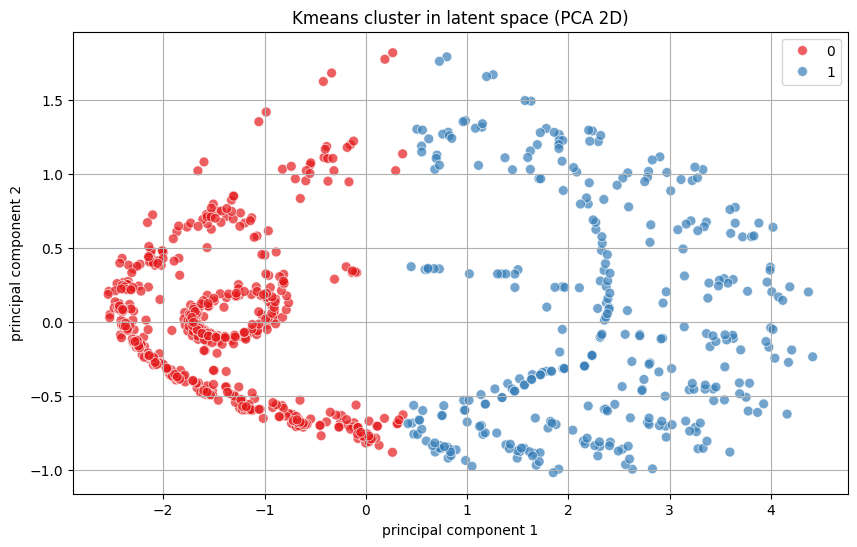

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latent_pca = pca.fit_transform(test_latent_vectors)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=latent_pca[:, 0], y=latent_pca[:, 1], hue=labels, palette='Set1', s=50, alpha=0.7)
plt.title("Kmeans cluster in latent space (PCA 2D)")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.grid(True)
plt.show()

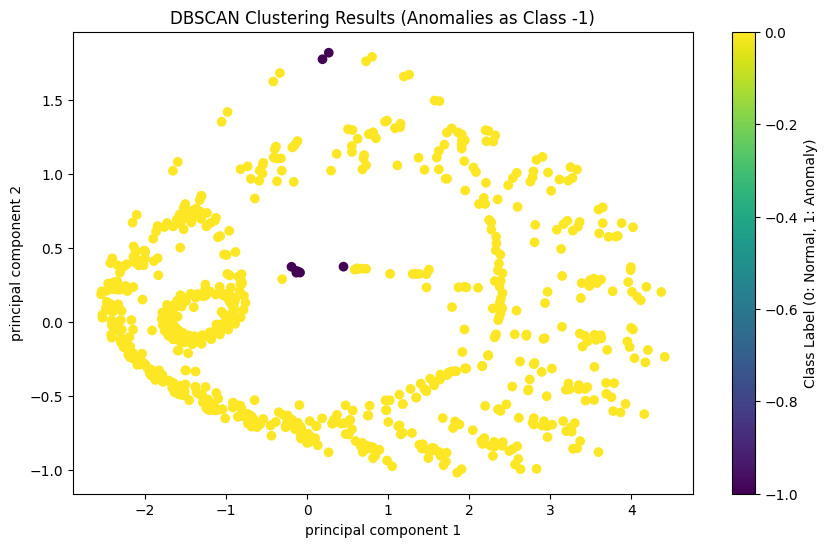

In [41]:
# Clustering algorithm that identifies data points in sparse regions as noise or anomalies

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)
clusters = dbscan.fit_predict(latent_pca)

# Initialize all points as 'normal' (class 0)
remapped_labels = np.zeros_like(clusters)
remapped_labels[clusters == -1] = 1

plt.figure(figsize=(10, 6))
# Color points based on their assigned cluster label
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.title('DBSCAN Clustering Results (Anomalies as Class -1)')
plt.colorbar(label='Class Label (0: Normal, 1: Anomaly)')
plt.show()

In [42]:
# Calculate metrics
dbscan_precision = precision_score(Y_test, remapped_labels, pos_label=1)
dbscan_recall = recall_score(Y_test, remapped_labels, pos_label=1)
dbscan_f1 = f1_score(Y_test, remapped_labels, pos_label=1)

print(f"DBSCAN Precision: {dbscan_precision:.4f}, Recall: {dbscan_recall:.4f}, F1-Score: {dbscan_f1:.4f}")

DBSCAN Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


In [43]:
plot_df = test_df.iloc[SEQ_LENGTH:].copy()

# Add predicted labels as new columns
plot_df['oc_svm_prediction'] = anomaly_labels
plot_df['kmeans_prediction'] = kmeans_anomaly_labels
plot_df['dbscan_prediction'] = remapped_labels

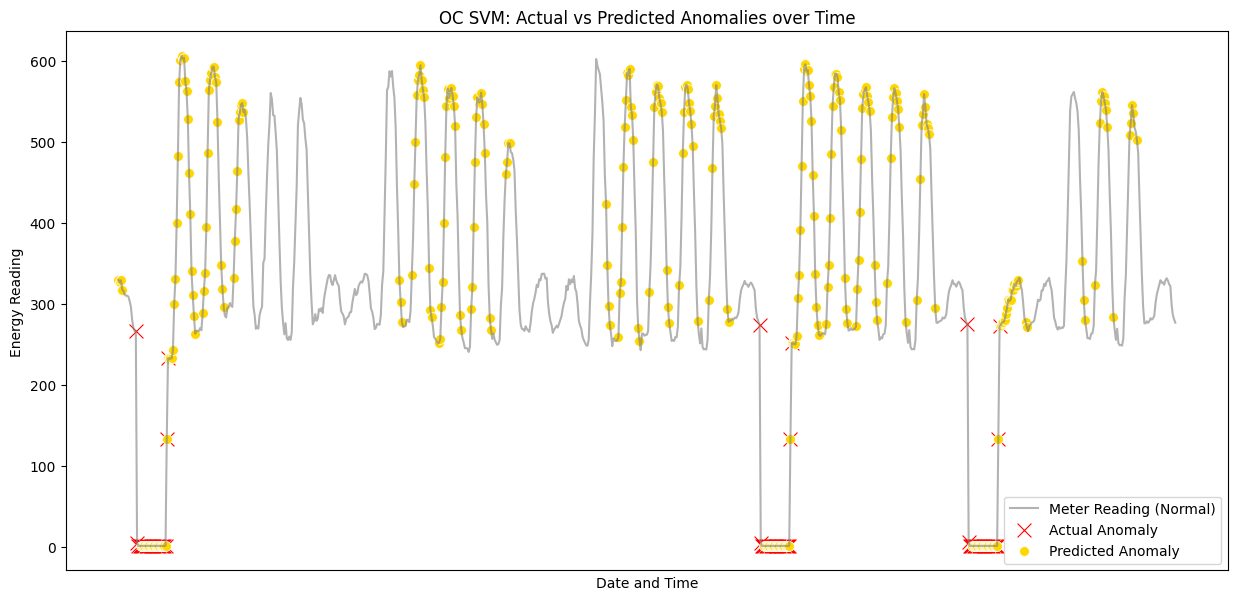

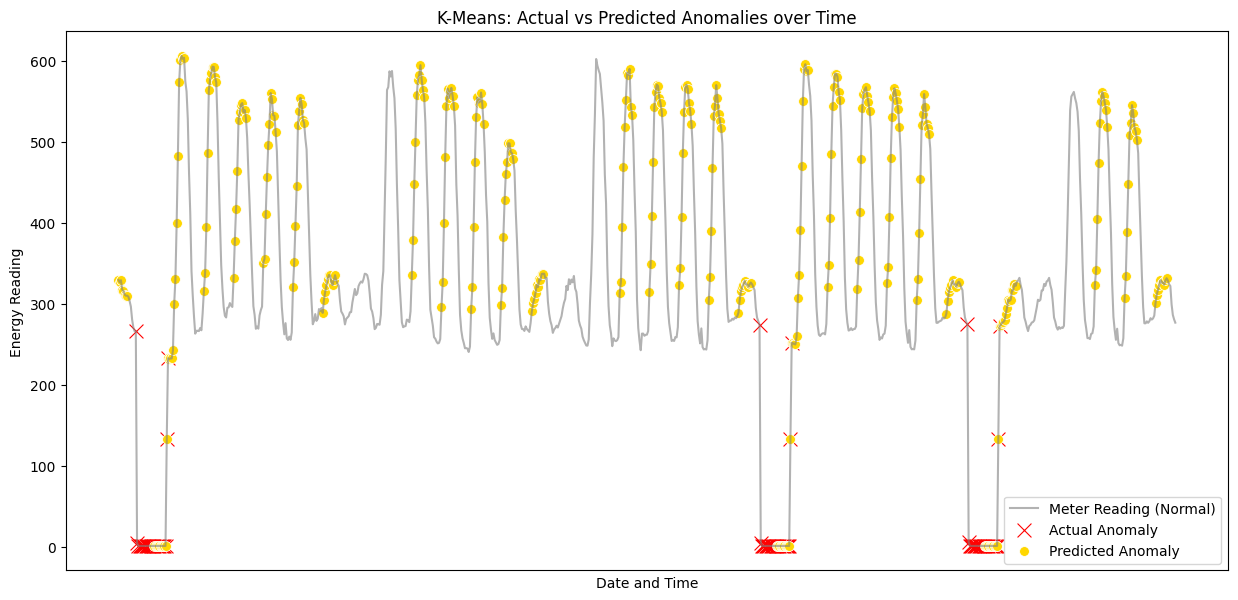

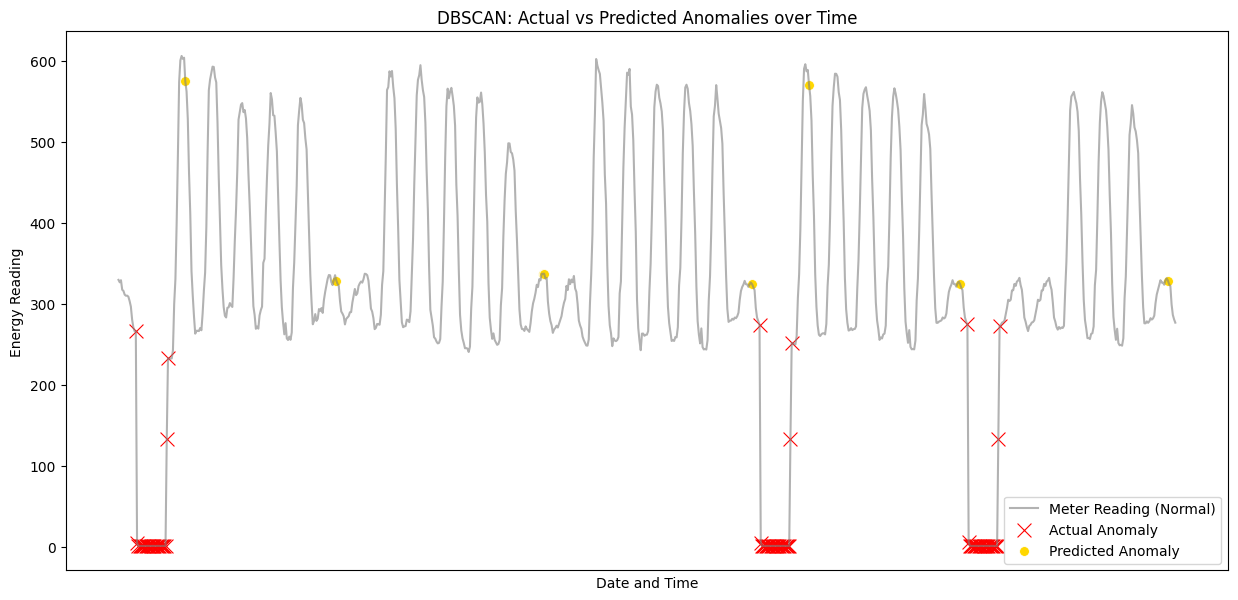

In [44]:
def plot_anomalies_comparison(df, model_pred_col, title):
    plt.figure(figsize=(15, 7))

    # Plot the original meter readings
    sns.lineplot(x='timestamp', y='meter_reading', data=df, label='Meter Reading (Normal)', color='gray', alpha=0.6)

    # Highlight ACTUAL anomalies in red
    actual_anomalies = df[df['anomaly'] == 1]
    sns.scatterplot(x='timestamp', y='meter_reading', data=actual_anomalies, color='red', marker='x', s=100, label='Actual Anomaly')

    # Highlight PREDICTED anomalies in orange/gold
    predicted_anomalies = df[df[model_pred_col] == 1]
    sns.scatterplot(x='timestamp', y='meter_reading', data=predicted_anomalies, color='gold', marker='o', s=50, label='Predicted Anomaly')

    plt.title(title)
    plt.xlabel('Date and Time')
    plt.ylabel('Energy Reading')
    plt.legend()
    plt.xticks([])
    plt.show()

# Generate plots for each model:
plot_anomalies_comparison(plot_df, 'oc_svm_prediction', 'OC SVM: Actual vs Predicted Anomalies over Time')

plot_anomalies_comparison(plot_df, 'kmeans_prediction', 'K-Means: Actual vs Predicted Anomalies over Time')

plot_anomalies_comparison(plot_df, 'dbscan_prediction', 'DBSCAN: Actual vs Predicted Anomalies over Time')